# Histogram

I need to get DFM's code working to estimate the histogram, since at the moment it does not appear to be a power law.

In [1]:
from __future__ import print_function, division

import numpy as np
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from george import kernels, GP
import fitters
sns.set_context('notebook', font_scale=1.5)
sns.set_style('whitegrid')

%matplotlib inline

/home/kgullikson/anaconda3/envs/python2/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


### Make sample of size 100. Each sample will have 10000 'MCMC' samples to estimate its uncertainty

In [38]:
# Generate the true distribution as a chi-squared, and then make all samples fall in [0,1]
NP_SEED=80
np.random.seed(NP_SEED)
true_q = np.random.chisquare(df=9, size=100)
true_q /= true_q.max()

# Generate samples for each true q from a truncated normal distribution
std = 0.05
a = -true_q / std
b = (1 - true_q) / std
q = np.vstack([stats.truncnorm.rvs(a=ai, b=bi, loc=true_qi, scale=std, size=10000) for ai, bi, true_qi in zip(a, b, true_q)])
#q = np.random.normal(loc=true_q, scale=0.1, size=(10000, true_q.size)).T
#q = np.random.chisquare(df=true_q, size=(10000, true_q.size)).T

(array([ 16.,  40.,  32.,   9.,   3.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

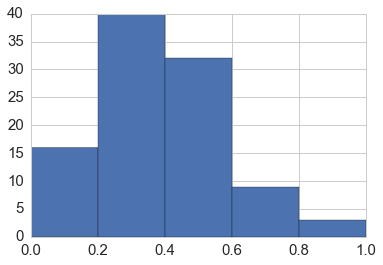

In [39]:
bins = np.arange(0, 1.05, 0.2)
plt.hist(true_q, bins=bins)

### Make a class that will fit this to a smooth distribution (no censoring yet)

In [40]:
class HistFitter(fitters.Bayesian_LS):
    def __init__(self, qvals, bin_edges):
        self.qvals = qvals
        self.bin_edges = bin_edges
        self.bin_centers = (self.bin_edges[:-1] + self.bin_edges[1:])/2
        self.bin_widths = np.diff(self.bin_edges)
        self.Nbins = self.bin_widths.size
        self.Nobs = self.qvals.shape[0]
        
        # Find which bin each q falls in
        self.bin_idx = np.digitize(self.qvals, self.bin_edges) - 1
        
        # Determine the censoring function for each bin (used in the integral)
        self.censor_integrals = np.array([integrate.quad(func=self.censoring_fcn,
                                                         a=left, b=right)[0] for (left, right) in 
                                          zip(self.bin_edges[:-1], self.bin_edges[1:])])
    
    def lnlike(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]
        
        # Normalize theta
        #theta /= np.sum(theta * self.bin_widths)
        
        # Generate the inner summation
        gamma = np.ones_like(self.bin_idx) * np.nan
        good = (self.bin_idx < self.Nbins) & (self.bin_idx >= 0) # nans in q get put in nonexistent bins
        gamma[good] = self.Nobs * self.censoring_fcn(self.qvals[good]) * theta[self.bin_idx[good]]
        summation = np.nanmean(gamma, axis=1)
        
        # Calculate the integral
        I = self._integral_fcn(theta)
        
        # Generate the log-likelihood
        ll = -I + np.nansum(np.log(summation))
        return ll
    
    def lnprior(self, pars):
        # Pull theta out of pars
        theta = pars[:self.Nbins]
        
        return 0.0
    
    def lnprob(self, pars):
        lp = self.lnprior(pars)
        return lp + self.lnlike(pars) if np.isfinite(lp) else -np.inf
    
    def _integral_fcn(self, theta):
        return np.sum(theta * self.censor_integrals) * self.Nobs
    
    def censoring_fcn(self, q):
        return 1.0
        
    def guess_fit(self):
        from scipy.optimize import minimize
        
        def errfcn(pars):
            ll = self.lnprob(pars)
            #print(pars, ll)
            return -ll

        initial_guess = np.ones_like(self.bin_centers)
        bounds = [[1e-3, None] for p in initial_guess]
        out = minimize(errfcn, initial_guess, bounds=bounds)
        return out.x
        

In [41]:
#bins = np.arange(0, 1.05, 0.1)
hf = HistFitter(q, bin_edges=bins)

In [42]:
theta, _ = np.histogram(true_q, bins=bins, normed=True)
hf.lnlike(theta)

389.25841202061883

In [43]:
fit_pars = hf.guess_fit()

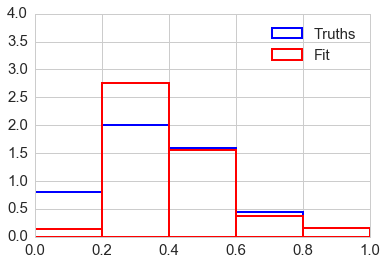

In [44]:
# Plot
plt.bar(left=bins[:-1], width=hf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=hf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

## That seems to work pretty well! Lets add some complexity by adding a censoring function

(-0.05, 1.05)

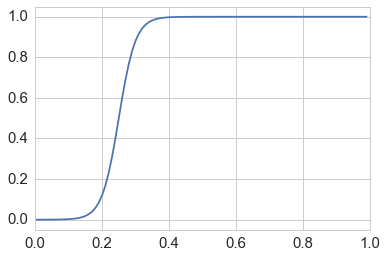

In [45]:
# I will make the censoring function be a sigmoid, but will only use the callable 
def sigmoid(q, alpha, beta):
    return 1.0 / (1.0 + np.exp(-alpha * (q - beta)))

alpha, beta = (40, 0.25)
x = np.arange(0, 1, 0.01)
Q = sigmoid(x, alpha, beta)
plt.plot(x, Q)
plt.ylim((-0.05, 1.05))

In [46]:
# Censor out some of the q, replacing all with nans
R = np.random.uniform(size=true_q.size)
undetected = R > sigmoid(true_q, alpha, beta)
censored_q = q.copy()
censored_q[undetected, :] = np.nan

(array([  1.,  33.,  32.,   9.,   3.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <a list of 5 Patch objects>)

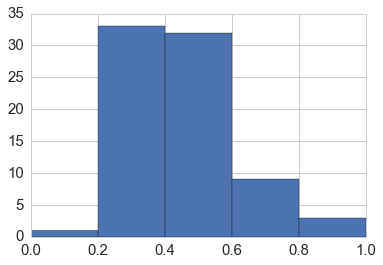

In [47]:
plt.hist(true_q[~undetected], bins=bins)

In [48]:
class CensoredHistFitter(HistFitter):
    def censoring_fcn(self, q):
        return sigmoid(q, alpha, beta)
        #return 1.0

In [49]:
chf = CensoredHistFitter(censored_q, bins)
fit_pars = chf.guess_fit()

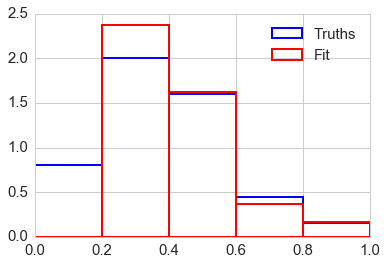

In [50]:
# Plot
plt.bar(left=bins[:-1], width=chf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=chf.bin_widths, height=fit_pars, label='Fit', fill=False, lw=2, edgecolor='red')
#plt.ylim((0, 6.0))
plt.legend(loc='best', fancybox=True)

### Cool! That mostly gives a reasonable answer too.

Now, I need to add a prior in the form of a gaussian process that forces the histogram to be 'smooth'

In [51]:
class SmoothHistFitter(CensoredHistFitter):
    def __init__(self, *args, **kwargs):
        super(SmoothHistFitter, self).__init__(*args, **kwargs)
        self.smoothing = self.qvals.shape[0] / self.Nbins
        self.n_params = self.Nbins + 4
        self.param_names = [r'$\theta_{}$'.format(i) for i in range(self.Nbins)]
        self.param_names.extend(('lna', 'lntau', 'lnerr', 'mean'))
        
    def lnprior(self, pars):
        theta = pars[:self.Nbins]
        if np.any(theta < 0):
            return -np.inf
        a, tau, err = np.exp(pars[self.Nbins:-1])
        mean = pars[-1]
        kernel = a * kernels.ExpSquaredKernel(tau)
        gp = GP(kernel, mean=mean)
        gp.compute(self.bin_centers, yerr=err)
        return gp.lnlikelihood(theta) / self.smoothing
    
    def guess_fit(self):
        from scipy.optimize import minimize
        
        def errfcn(pars):
            ll = self.lnprob(pars)
            #print(pars, ll)
            return -ll

        initial_guess = np.ones(self.bin_centers.size + 4)
        initial_guess[-4] = 0.0
        initial_guess[-3] = -0.25
        initial_guess[-2] = -1.0
        initial_guess[-1] = -1.0
        bounds = [[1e-3, None] for p in self.bin_centers]
        bounds.append([-10, 20])
        bounds.append([-10, 10])
        bounds.append((-1, 5))
        bounds.append((-10, 10))
        out = minimize(errfcn, initial_guess, bounds=bounds)
        return out.x
    
    def _lnlike(self, pars):
        return self.lnprob(pars)
    
    def mnest_prior(self, cube, ndim, nparams):
        for i in range(self.Nbins):
            cube[i] *= 10
        #cube[:self.Nbins] *= 15
        cube[self.Nbins] = cube[self.Nbins] * 30 - 10
        cube[self.Nbins+1] = cube[self.Nbins+1] * 20 - 10
        cube[self.Nbins+2] = cube[self.Nbins+2] * 7 - 2
        cube[self.Nbins+3] = cube[self.Nbins+3] * 20 - 10
        return
        
        

In [52]:
shf = SmoothHistFitter(censored_q, bins)
#shf.lnprob(fit_pars)

In [53]:
fit_pars = shf.guess_fit()

In [54]:
print(fit_pars)

[  1.00000000e-03   2.35645452e+00   1.62410553e+00   3.71731585e-01
   1.61032899e-01  -9.14621292e+00  -2.88028914e-01  -7.77410469e-02
   9.02756604e-01]


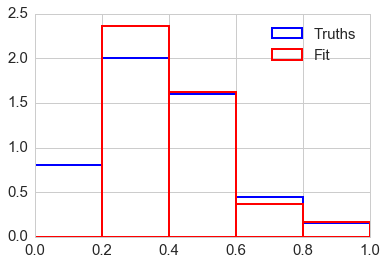

In [55]:
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=fit_pars[:-4], label='Fit', fill=False, lw=2, edgecolor='red')
#plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

In [56]:
shf.Nbins, shf.bin_centers

(5, array([ 0.1,  0.3,  0.5,  0.7,  0.9]))

In [57]:
#shf.n_params = shf.Nbins + 4
#shf.param_names = [r'$\theta_{}$'.format(i) for i in range(shf.Nbins)]
#shf.param_names.extend(('lna', 'lntau', 'lnerr', 'mean'))
shf.fit_multinest(basename='HistFitterTest/simulation{}'.format(NP_SEED), overwrite=True)

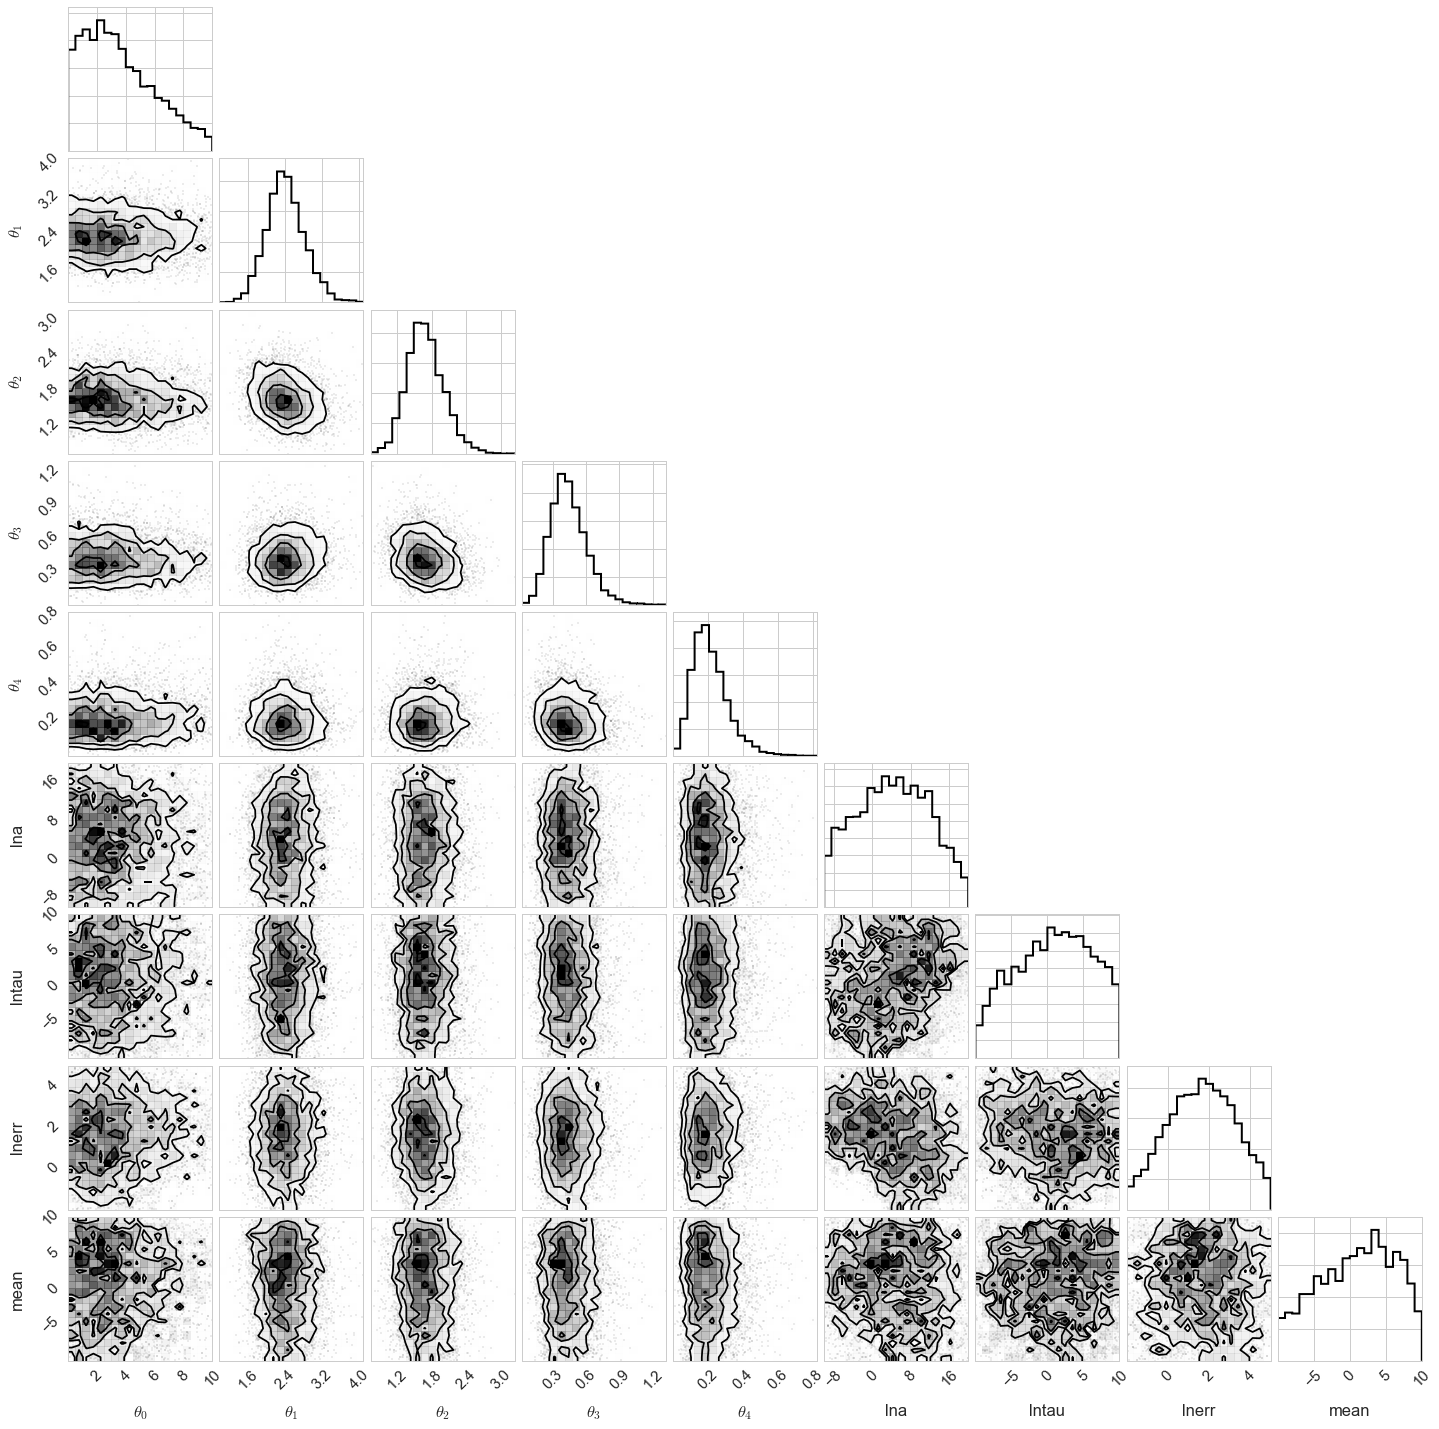

In [58]:
shf.triangle(hist_kwargs=dict(lw=2))

In [59]:
shf.samples.describe()

,$\theta_0$,$\theta_1$,$\theta_2$,$\theta_3$,$\theta_4$,lna,lnerr,lnprob,lntau,mean
count,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000,5348.000000
mean,3.600812,2.418071,1.693086,0.441504,0.217472,4.393920,1.646059,295.775582,0.814393,0.907225
std,2.409864,0.411396,0.315906,0.162552,0.104540,7.380601,1.600195,1.506583,5.132511,5.123553
min,0.000672,0.986771,0.747898,0.016680,0.003178,-9.980210,-1.981784,283.785341,-9.988030,-9.990118
25%,1.650542,2.139426,1.476953,0.328049,0.144422,-1.404895,0.474544,295.057007,-3.145962,-3.068685
50%,3.168759,2.394998,1.668556,0.424695,0.199990,4.412353,1.676192,296.067399,1.061410,1.331179
75%,5.239117,2.669543,1.884797,0.537561,0.273214,10.240066,2.860296,296.854136,4.954198,5.035835
max,9.999096,4.093436,3.230364,1.318822,0.823335,19.995486,4.996571,298.252419,9.998846,9.999496


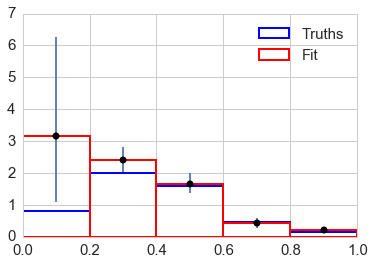

In [60]:
height_mean = np.array([shf.samples[col].mean() for col in shf.param_names[:shf.Nbins]])
height_std = np.array([shf.samples[col].std() for col in shf.param_names[:shf.Nbins]])
l, m, h = np.array([np.percentile(shf.samples[col], [16, 50, 84]) for col in shf.param_names[:shf.Nbins]]).T
plt.bar(left=bins[:-1], width=shf.bin_widths, height=theta, label='Truths', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='Fit', fill=False, lw=2, edgecolor='red')
plt.plot(shf.bin_centers, m, 'ko')
#plt.ylim((0, 4.0))
plt.legend(loc='best', fancybox=True)

# This works quite nicely!
The uncertainties tend to be very large, especially on the lowest q bin where completeness is very low, but that is fine. I have tried it on several different random seeds, and it always gives a reasonable answer.

# Malmquist bias

The last thing to test out is the malmquist bias correction. My approach is to forward model the effect of malmquist bias onto the observed bin heights, so that I can still compare in a similar was as above. 

In [61]:
# Set the malmquist bias parameters. This comes from a simulation in Malmquist_Bias.ipynb
malm_pars = np.array([-0.02042249,  0.04079731, -0.0227729 ,  0.01252475, -0.00095515, 0.00712293])

In [64]:
def _integrate_malmquist(malm_pars, q0, q1):
        """ Integrate the malmquist-correction factor from q0 --> q1
        """
        return np.sum([p/(i+1.0)*(q1**(i+1.0) - q0**(i+1.0)) for i, p in enumerate(malm_pars)])
    
def _fit_thetas(raw_thetas, malm_integrals):
        thetas = np.array(raw_thetas)
        thetas[:-1] = np.array([malm_integrals[-1]/Mi * p for Mi, p in zip(malm_integrals[:-1], raw_thetas[:-1])])
        return thetas

def correct_malmquist(bin_edges, bin_heights, malm_pars):
    """ Apply a correction to the fitted bin heights to account for malmquist bias
    """
    # First, calculate the malmquist integrals for every bin
    malm_integrals = np.array([_integrate_malmquist(malm_pars, q0, q1) for q0, q1 
                                in zip(bin_edges[:-1], bin_edges[1:])])
    
    # Calculate new un-normalized bin heights
    malm_vals = _fit_thetas(bin_heights, malm_integrals)
    
    # Normalize such that the sum is the same as the original
    bin_widths = np.diff(bin_edges)
    norm = np.sum(malm_vals * bin_widths) / np.sum(bin_heights * bin_widths)
    malm_vals /= norm
    return malm_vals
    
    

In [67]:
# Test out on the median bin heights from the previous fit
new_theta = correct_malmquist(bin_edges=bins, bin_heights=m, malm_pars=malm_pars[::-1])
print(m)
print(new_theta)

[ 3.16875853  2.394998    1.66855617  0.42469466  0.19999014]
[ 3.49534158  2.47023771  1.48284008  0.2997476   0.10883053]


In [75]:
# Apply to all of the MCMC samples
current_heights = shf.samples[shf.param_names[:shf.Nbins]].as_matrix()
new_heights = np.vstack([correct_malmquist(bins, height, malm_pars[::-1]) for height in current_heights])

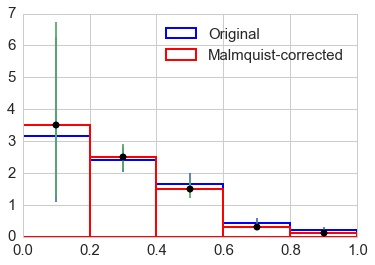

In [81]:
# Plot the malmquist-corrected heights, with errors
l2, m2, h2 = np.percentile(new_heights, [16, 50, 84], axis=0)
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m, yerr=(m-l, h-m), label='Original', fill=False, lw=2, edgecolor='blue')
plt.bar(left=bins[:-1], width=shf.bin_widths, height=m2, yerr=(m2-l2, h2-m2), label='Malmquist-corrected', fill=False, lw=2, edgecolor='red')
plt.plot(shf.bin_centers, m2, 'ko')
plt.legend(loc='best', fancybox=True)

There really isn't much change between the before- and after-histograms. However, it does go in the expected direction: low mass-ratios go up and high mass-ratios go down.